### Table 1: Diagnostic summary

In [1]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from utils.data import load_tc_data
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

# https://gist.github.com/sudomaze/444473e113a815624edfa1647df32953

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def calculate_crps(observation, forecasts):
	# forecasts = forecasts[...,None]
	fc = forecasts.copy()
	fc.sort(axis=-1)
	obs = observation
	fc_below = fc < obs[..., None]
	crps = np.zeros_like(obs)

	for i in range(fc.shape[-1]):
		below = fc_below[..., i]
		weight = ((i+1)**2 - i**2) / fc.shape[-1]**2
		crps[below] += weight * (obs[below]-fc[..., i][below])

	for i in range(fc.shape[-1] - 1, -1, -1):
		above = ~fc_below[..., i]
		k = fc.shape[-1] - 1 - i
		weight = ((k+1)**2 - k**2) / fc.shape[-1]**2
		crps[above] += weight * (fc[..., i][above] - obs[above])

	return crps

In [3]:
def plot_histogram(real,pred,binwidth,alpha,type='Mean'):
        """
        This function plots a histogram of the set in question
        """
        # ax = sns.histplot(data=penguins, x="flipper_length_mm", hue="species", element="step")
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(ax=ax,data=real, stat="density", fill=True,color='#b5a1e2',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred, stat="density", fill=True,color='#dc98a8',element='step',alpha=alpha)
        ax.set_xlabel('Mean or Peak rainfall (mm/h)',size=18)
        ax.set_xlabel('%s Rainfall (mm/h)' % type,size=18)
        ax.set_ylabel('Density',size=18)
        plt.legend(labels=['real','pred'],fontsize=24)
        plt.show()
        # plt.savefig('figs/histogram_accumulated_%s.png' % mode)

def calc_peak(array):
        nstorms,_,_ = array.shape
        peaks = np.zeros((nstorms))
        for i in range(nstorms):
                peaks[i] = np.nanmax(array[i])
        return peaks

def calc_mean(array):
        nstorms,_,_ = array.shape
        means = np.zeros((nstorms))
        for i in range(nstorms):
                means[i] = np.nanmean(array[i])
        return means

In [4]:

model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='test',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_test',results='test')

# load datasets

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)


(16362, 10, 10)
(16007, 100, 100)


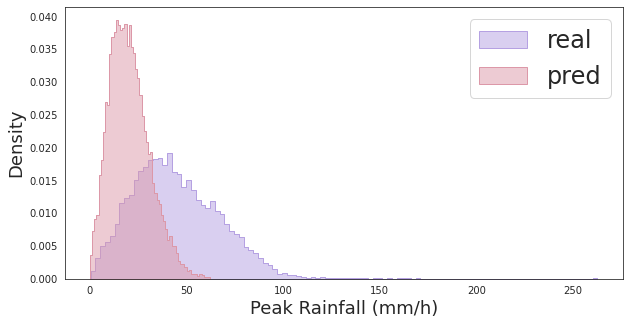

KstestResult(statistic=0.545261448116449, pvalue=0.0)
KstestResult(statistic=0.545261448116449, pvalue=0.0)


In [5]:
# metric 1
# A standard metric to check how the distributions compare
# TODO: integrate ensemble predictions
# distributions


pred = inputs_hr
def distribution(real,pred):
	peak_reals = calc_peak(real)
	peak_preds = calc_peak(pred)
	plot_histogram(peak_reals,peak_preds,5,0.5,type = 'Peak')
	ks = stats.kstest(peak_reals, peak_preds)
	print(ks)
	ks = stats.ks_2samp(peak_reals, peak_preds)
	print(ks)

	mean_reals = calc_mean(real)
	mean_preds = calc_mean(pred)
	plot_histogram(mean_reals,mean_preds,5,0.5)
	ks = stats.kstest(mean_reals, mean_preds)
	print(ks)
	ks = stats.kstest(mean_preds,mean_preds)
	print(ks)


	print('mean real: ',np.mean(real))
	print('mean pred: ', np.mean(pred))
	print('std real: ',np.std(real))
	print('std pred: ',np.std(pred))

distribution(real,pred)
# ks null hypothesis: two samples drawn from populations with the same distributions
# if p-value is small then you can reject the null hypothesis
# I think we want the p value to be large? or close to 1?

# TODO: could do the same thing for the 90th percentile or just the extreme validation set

In [ ]:
# metric 2 
# common probabilistic forecasting score
# CRPS
crps = calculate_crps(real,pred_vaegan_ensemble)
print(crps.shape)
# print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

vaegan_crps = np.mean(crps)
print(vaegan_crps)
vaegan_x_crps = np.mean(calculate_crps(real_x,pred_vaegan_ensemble_x))



crps = ps.crps_ensemble(real,pred_gan_ensemble)
print(crps.shape)
print(np.mean(crps))
print('mean crps: ',np.mean(crps))

gan_crps = np.mean(crps)
gan_x_crps = np.mean(ps.crps_ensemble(real_x,pred_gan_ensemble_x))

(16007, 100, 100)
[0.98797982 0.3673076  0.30978086 ... 0.25056888 0.27886392 0.23883523]
0.548044055804649
0.548044055804649
(16007, 100, 100)
0.5145600939168123
mean crps:  0.5145600939168123


In [ ]:
# metric 3
# standard sanity check, though not usually for stochastic models
# RMSE
nimages,_,_ = real.shape

# TODO: change cnn shape
print(pred_cnn.shape)
print(pred_vaegan.shape)
print(pred_gan.shape)
print(real.shape)
def rmse_calc(pred):
	RMSE = []
	for i in range(nimages):
		rmse = sqrt(mean_squared_error(real[i], pred[i]))
		RMSE.append(rmse)
	return np.mean(RMSE)

gan_rmse = rmse_calc(pred_gan)
vaegan_rmse = rmse_calc(pred_vaegan)
cnn_rmse = rmse_calc(pred_cnn)
inputs_hr_rmse = rmse_calc(inputs_hr)

(16007, 100, 100)
(16007, 100, 100)
(16007, 100, 100)
(16007, 100, 100)


In [ ]:
# metric 4
# metric to look specifically at spatial structure
# power spectra

def log_spectral_distance(img1, img2):
	def power_spectrum_dB(img):
		fx = np.fft.fft2(img)
		fx = fx[:img.shape[0]//2, :img.shape[1]//2]
		px = abs(fx)**2
		return 10 * np.log10(px)

	d = (power_spectrum_dB(img1)-power_spectrum_dB(img2))**2

	d[~np.isfinite(d)] = np.nan
	return np.sqrt(np.nanmean(d))


def log_spectral_distance_batch(batch1, batch2):
	lsd_batch = []
	for i in range(batch1.shape[0]):
		lsd = log_spectral_distance(
				batch1[i, :, :], batch2[i, :, :]
			)
		lsd_batch.append(lsd)
	return np.array(lsd_batch)

lsd_inputs = log_spectral_distance_batch(inputs_hr,real)
# print('inputs:')
# print(lsd)
# print(lsd.mean())

lsd_cnn = log_spectral_distance_batch(pred_cnn,real)
# print('cnn:')
# print(lsd)
# print(lsd.mean())

lsd_vaegan = log_spectral_distance_batch(pred_vaegan,real)
# print('vaegan:')
# print(lsd)
# print(lsd.mean())

lsd_gan = log_spectral_distance_batch(pred_gan,real)
# print('dsrnngan:')
# print(lsd)
# print(lsd.mean())

In [9]:
# metric 6
# Accumulated Rainfall

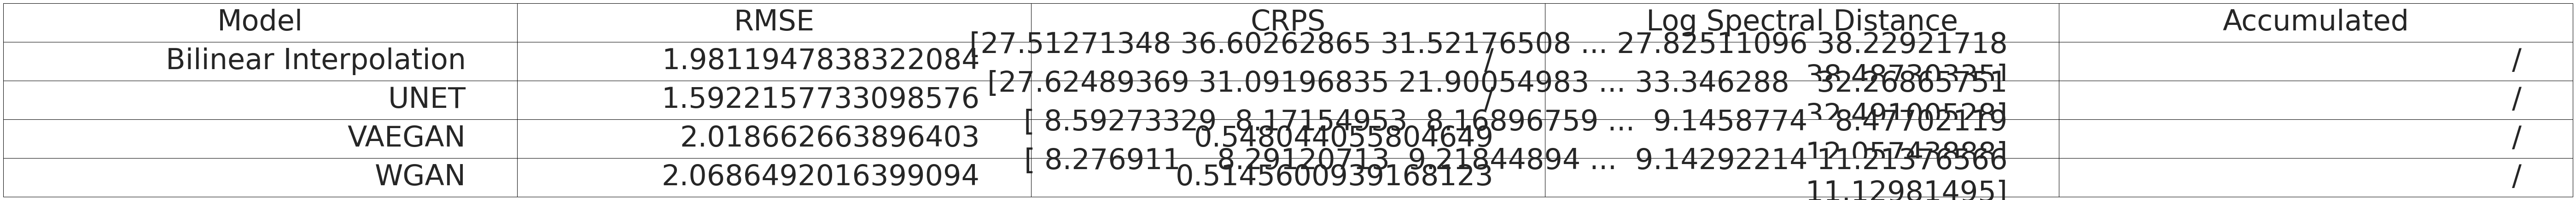

In [ ]:
# plot table
fig, ax = plt.subplots(figsize=(10,5))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


df = pd.DataFrame({
					'Model' : ['Bilinear Interpolation','UNET','VAEGAN','WGAN'],
					'RMSE'	: [inputs_hr_rmse,cnn_rmse,vaegan_rmse,gan_rmse],
					'CRPS'	: ['/','/',vaegan_crps,gan_crps],
					'Log Spectral Distance'	: [lsd_inputs,lsd_cnn,lsd_vaegan,lsd_gan],
					# 'Similarity Score'	: ['/','/','/','/'],
					'Accumulated'	: ['/','/','/','/']
})
# df = pd.DataFrame(np.random.randn(5, 6), columns=['Model','RMSE','CRPS','LSD','SS','Accumulated'])

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
# pd.plotting.table(ax,df,loc='top')
table.auto_set_font_size(False)
table.set_fontsize(62)
table.scale(10, 7)

fig.tight_layout()
plt.savefig('table.png')
plt.show()


In [ ]:
# Timings on test set
# cnn = 10 seconds